# Final EDA: Amazon Sports & Outdoors Dataset

- This notebook performs structured Exploratory Data Analysis (EDA) on the final joined dataset generated from our Phase 1 ETL pipeline.
- The dataset (`final_joined.parquet`) contains 1.5 million filtered user reviews enriched with product metadata from Amazon's Sports & Outdoors category.

## Goals:
- Understand the schema, column types, and data volume
- Analyze the distribution of key numeric and categorical fields (e.g., ratings, prices, brands, categories)
- Detect and quantify missing or null values
- Check for duplicates or inconsistencies
- Identify patterns relevant to downstream modeling tasks (e.g., cold-start analysis, feature sparsity)
- Prepare for feature selection and vectorization in Phase 2 (deep learning models)

In [29]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import json
import ast
import re

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Avoid line wraps

Users & Item Original Datasets


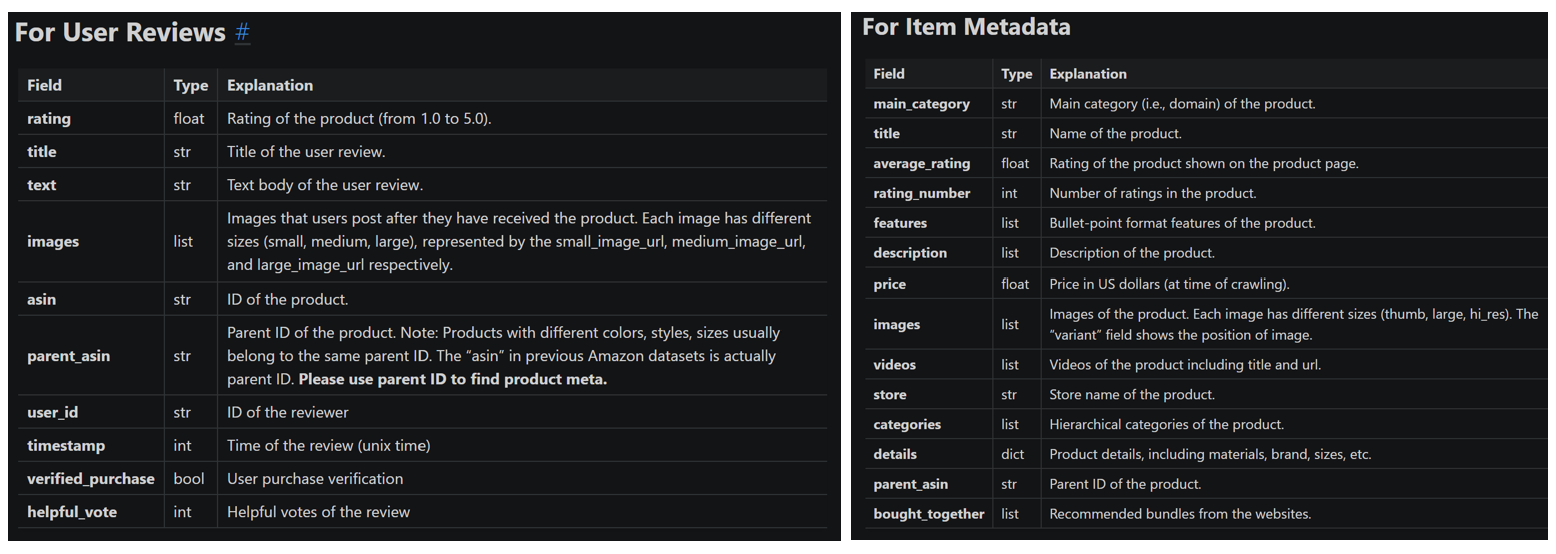

In [30]:
# Below the original datasets - Users & Item for reference

print(f'Users & Item Original Datasets')
display(Image(r"C:\Users\dolly\Desktop\sports-collection-recommender\docs\Users & Item.png",
                  width=1200  # adjust as needed
))

In [31]:
# Helper Functions

# Mark Columns to their Respective Dataset Origin (Either Users or Item)
def rename_user_item_columns(df: pd.DataFrame) -> pd.DataFrame:
    def transform(col):
        if col.endswith('_review'):
            return f'users_{col.replace("_review", "")}'
        elif col.endswith('_meta'):
            return f'item_{col.replace("_meta", "")}'
        elif col in {
            'rating', 'text', 'asin', 'parent_asin', 'user_id',
            'timestamp', 'helpful_vote', 'verified_purchase'
        }:
            return f'users_{col}'
        elif col in {
            'main_category', 'average_rating', 'rating_number',
            'features', 'description', 'price', 'videos',
            'store', 'categories', 'details', 'bought_together'
        }:
            return f'item_{col}'
        elif col == 'title':
            return col  # let suffix rule handle it
        else:
            return col  # fallback

    return df.rename(columns={col: transform(col) for col in df.columns})

def clean_amazon_recommender_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pure cleaning function for Amazon recommender system dataset.
    - Standardizes text fields (lowercase, trim, bracket removal)
    - Filters invalid ratings and prices
    - Drops rows with missing critical fields
    - Logs actions taken
    - Does NOT perform any feature engineering
    """

    def log_action(step: str, df_in: pd.DataFrame, df_out: pd.DataFrame):
        dropped = len(df_in) - len(df_out)
        print(f"{step}: {len(df_out)} rows retained (dropped {dropped})")

    def clean_text(text):
        if not isinstance(text, str):
            return text
        text = text.strip().lower()
        return re.sub(r"^[\[\{\"]+|[\]\}\"]+$", "", text)

    extra_text_fields = [
        'title_review', 'text', 'verified_purchase', 'main_category', 'title_meta',
        'features', 'description', 'videos', 'store', 'categories', 'details',
        'images_review', 'images_meta'
    ]

    print(f"Starting data cleaning... Original rows: {len(df)}")

    for col in extra_text_fields:
        if col in df.columns:
            df[col] = df[col].astype(str).apply(clean_text)
    print(f"Cleaned {len(extra_text_fields)} auxiliary text fields")

    essential_cols = [
        'users_user_id',
        'users_parent_asin',
        'users_rating',
        'item_title',
        'item_categories',
        'item_price',
        'item_main_category'
    ]

    df_final = df[essential_cols].copy()
    print(f"Subset to essential columns: {df_final.shape[1]} columns")

    # Clean all object-type columns
    for col in df_final.select_dtypes(include='object').columns:
        if col != 'item_categories':  # skip this column
            df_final[col] = df_final[col].astype(str).str.strip().str.lower()
            df_final[col] = df_final[col].str.replace(r"^[\[\{\"]+|[\]\}\"]+$", "", regex=True)
    print(f"Standardized object-type fields")

    # Drop duplicates
    before = df_final.copy()
    df_final = df_final.drop_duplicates()
    log_action("Dropped duplicate rows", before, df_final)

    # Drop rows with missing values in critical fields
    before = df_final.copy()
    df_final = df_final.dropna(subset=[
        'users_user_id', 'users_parent_asin', 'users_rating', 'item_title'
    ])
    log_action("Dropped rows with missing critical fields", before, df_final)

    # Filter ratings to 1–5
    before = df_final.copy()
    df_final = df_final[df_final['users_rating'].between(1, 5)]
    log_action("Filtered ratings outside 1–5", before, df_final)

    # Filter prices to $1–1000
    before = df_final.copy()
    df_final['item_price'] = pd.to_numeric(df_final['item_price'], errors='coerce')
    df_final = df_final[df_final['item_price'].between(1, 1000)]
    log_action("Filtered prices outside $1–1000", before, df_final)

    df_final = df_final.reset_index(drop=True)

    # Null report
    print("\nMissing values per column (after cleaning):")
    nulls = df_final.isnull().sum()
    has_nulls = nulls[nulls > 0]
    if not has_nulls.empty:
        print(has_nulls.sort_values(ascending=False))
    else:
        print("No missing values remaining.")

    print(f"Final cleaned dataset: {len(df_final)} rows × {df_final.shape[1]} columns")
    return df_final

# Extract the last (leaf) category from item_categories
def extract_leaf_category(cat):
    try:
        parsed = json.loads(cat) if isinstance(cat, str) and cat.strip().startswith('[') else []
        return parsed[-1] if parsed else None
    except:
        return None

## 1. Rough Glance of `final_joined.parquet`

In [32]:
# Load the dataset
df = pd.read_parquet('../data/processed/final_joined.parquet')

# Basic dataset info
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

Dataset shape: (1500000, 25)
Rows: 1,500,000, Columns: 25


In [33]:
# Display all columns and their types
print("Column names and data types:")
print("-" * 40)
for col, dtype in df.dtypes.items():
    print(f"{col:<20} {dtype}")

Column names and data types:
----------------------------------------
rating               float64
title_review         object
text                 object
images_review        object
asin                 object
parent_asin          object
user_id              object
timestamp            int64
helpful_vote         int64
verified_purchase    bool
main_category        object
title_meta           object
average_rating       float64
rating_number        int64
features             object
description          object
price                float64
images_meta          object
videos               object
store                object
categories           object
details              object
bought_together      object
subtitle             object
author               object


In [34]:
print("Unique ratings:", df['rating'].nunique())
print("\nRating value counts:")
print(df['rating'].value_counts().sort_index())

Unique ratings: 5

Rating value counts:
rating
1.0     103447
2.0      62997
3.0      94229
4.0     188060
5.0    1051267
Name: count, dtype: int64


In [35]:
# Show first 3 rows of the full dataset
print("First 3 Rows (Transposed):")
display(df.head(3).T)

First 3 Rows (Transposed):


,0,1,2
rating,1.0,1.0,5.0
title_review,Falls OFF during runs / FLAWED DESIGN / WEAK...,Only 1 worked correctly,Lightweight and quiet
text,Let's start with the positives. It is a nice ...,I ordered this set right before my camping tri...,This bike is nice and simple. Easy to build an...
images_review,[],[],[]
asin,B00PUO6KCI,B018L2WM86,B07L9TTXG4
parent_asin,B0B7QYSGRP,B09LW2KHPM,B0BTDLFXSL
user_id,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,AGO25X54UAIXSKHOAH4SG2VUDUNA,AHGGRLIBAWVH44XAY2QHQOE7S6OQ
timestamp,1432828623000,1605078655679,1589755246636
helpful_vote,10,1,0
verified_purchase,True,True,True


In [36]:
# Display transposed to see all columns
df = rename_user_item_columns(df)
df.head(3).T

,0,1,2
users_rating,1.0,1.0,5.0
users_title,Falls OFF during runs / FLAWED DESIGN / WEAK...,Only 1 worked correctly,Lightweight and quiet
users_text,Let's start with the positives. It is a nice ...,I ordered this set right before my camping tri...,This bike is nice and simple. Easy to build an...
users_images,[],[],[]
users_asin,B00PUO6KCI,B018L2WM86,B07L9TTXG4
users_parent_asin,B0B7QYSGRP,B09LW2KHPM,B0BTDLFXSL
users_user_id,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,AGO25X54UAIXSKHOAH4SG2VUDUNA,AHGGRLIBAWVH44XAY2QHQOE7S6OQ
users_timestamp,1432828623000,1605078655679,1589755246636
users_helpful_vote,10,1,0
users_verified_purchase,True,True,True


In [37]:
# Check memory usage - important for large datasets
print("Memory usage:")
print(f"Total memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print("\nTop memory consumers:")
memory_usage = df.memory_usage(deep=True).sort_values(ascending=False)
for col, usage in memory_usage.head(5).items():
    if col != 'Index':
        print(f"{col:<20} {usage / 1024**2:.1f} MB")

Memory usage:
Total memory: 10280.6 MB

Top memory consumers:
item_images          2312.5 MB
item_features        2179.1 MB
item_videos          1922.8 MB
item_description     1106.5 MB
item_details         1058.3 MB


## 2. Select Essential Columns for Full Pipeline of Our Project

| Column               | Purpose                                                            |
| -------------------- | ------------------------------------------------------------------ |
| `users_user_id`      | Unique user identifier for personalization and interaction history |
| `users_parent_asin`  | Core item ID used for modeling user-item interactions              |
| `users_rating`       | Explicit feedback (label for supervised or ranking models)         |
| `item_title`         | Display name, and useful for keyword-based search or embedding     |
| `item_categories`    | Hierarchical grouping for content-based filtering or analysis      |
| `item_price`         | Numeric feature for price-aware modeling or filtering              |
| `item_main_category` | Simplified categorical label for grouping, stratification, etc.    |


In [38]:
# Define the essential columns to retain
essential_cols = [
    'users_user_id',
    'users_parent_asin',
    'users_rating',
    'item_title',
    'item_categories',
    'item_price',
    'item_main_category'
]

# Keep only those columns (drop all others)
df_final_cols = df[essential_cols].copy()

print("Trimmed DataFrame shape:", df_final_cols.shape)
print("Columns retained:", df_final_cols.columns.tolist())

display(df_final_cols.head(3))

Trimmed DataFrame shape: (1500000, 7)
Columns retained: ['users_user_id', 'users_parent_asin', 'users_rating', 'item_title', 'item_categories', 'item_price', 'item_main_category']


,users_user_id,users_parent_asin,users_rating,item_title,item_categories,item_price,item_main_category
0,AE6SZO6FUM4UE7WCZO7UGP7QA5AA,B0B7QYSGRP,1.0,"Running Buddy Magnetic Buddy Pouch, Beltess, C...","[""Sports & Outdoors"",""Sports"",""Running"",""Waist...",19.99,None
1,AGO25X54UAIXSKHOAH4SG2VUDUNA,B09LW2KHPM,1.0,"Vont LED Camping Lantern, LED Lanterns, Suitab...","[""Sports & Outdoors"",""Outdoor Recreation"",""Cam...",14.38,Sports & Outdoors
2,AHGGRLIBAWVH44XAY2QHQOE7S6OQ,B0BTDLFXSL,5.0,ATIVAFIT Exercise Bike Foldable Fitness Indoor...,"[""Sports & Outdoors"",""Exercise & Fitness"",""Car...",139.99,Sports & Outdoors


In [39]:
# Perform purely cleaning

df_cleaned = clean_amazon_recommender_data(df_final_cols)
print(df_cleaned.shape)
df_cleaned.head()

Starting data cleaning... Original rows: 1500000
Cleaned 13 auxiliary text fields
Subset to essential columns: 7 columns
Standardized object-type fields
Dropped duplicate rows: 1487751 rows retained (dropped 12249)
Dropped rows with missing critical fields: 1487751 rows retained (dropped 0)
Filtered ratings outside 1–5: 1487751 rows retained (dropped 0)
Filtered prices outside $1–1000: 1325684 rows retained (dropped 162067)

Missing values per column (after cleaning):
No missing values remaining.
Final cleaned dataset: 1325684 rows × 7 columns
(1325684, 7)


,users_user_id,users_parent_asin,users_rating,item_title,item_categories,item_price,item_main_category
0,ae6szo6fum4ue7wczo7ugp7qa5aa,b0b7qysgrp,1.0,"running buddy magnetic buddy pouch, beltess, c...","[""Sports & Outdoors"",""Sports"",""Running"",""Waist...",19.99,none
1,ago25x54uaixskhoah4sg2vuduna,b09lw2khpm,1.0,"vont led camping lantern, led lanterns, suitab...","[""Sports & Outdoors"",""Outdoor Recreation"",""Cam...",14.38,sports & outdoors
2,ahggrlibawvh44xay2qhqoe7s6oq,b0btdlfxsl,5.0,ativafit exercise bike foldable fitness indoor...,"[""Sports & Outdoors"",""Exercise & Fitness"",""Car...",139.99,sports & outdoors
3,afemumklc4w5pvhealewmc25aojq,b0b8t4m8ky,5.0,balancefrom puzzle exercise mat with eva foam ...,"[""Sports & Outdoors"",""Exercise & Fitness"",""Acc...",129.99,sports & outdoors
4,agosuqaeytc5a6ydij7x5zfaosiq,b09w4w9jb5,5.0,alps mountaineering lynx 1-person backpacking ...,"[""Sports & Outdoors"",""Outdoor Recreation"",""Cam...",109.99,sports & outdoors


In [40]:
# EDA: Categorical Summary: Unique Counts + Top 5 Values
print("\nCategorical column summary:")

categorical_summary = []

for col in df_cleaned.select_dtypes(include=['object', 'category']).columns:
    top_vals = df_cleaned[col].value_counts().head(5)
    categorical_summary.append({
        "Column": col,
        "Unique Values": df_cleaned[col].nunique(),
        "Top 1": f"{top_vals.index[0]} ({top_vals.iloc[0]})" if len(top_vals) > 0 else "",
        "Top 2": f"{top_vals.index[1]} ({top_vals.iloc[1]})" if len(top_vals) > 1 else "",
        "Top 3": f"{top_vals.index[2]} ({top_vals.iloc[2]})" if len(top_vals) > 2 else "",
        "Top 4": f"{top_vals.index[3]} ({top_vals.iloc[3]})" if len(top_vals) > 3 else "",
        "Top 5": f"{top_vals.index[4]} ({top_vals.iloc[4]})" if len(top_vals) > 4 else "",
    })

categorical_summary_df = pd.DataFrame(categorical_summary)
display(categorical_summary_df.set_index("Column").T)


Categorical column summary:


Column,users_user_id,users_parent_asin,item_title,item_categories,item_main_category
Unique Values,1068509,1101,1100,374,22
Top 1,afzuk3mtbibedqopak3oatuoukla (28),b00nwxlqd2 (13379),fitbit charge hr wireless activity wristband (...,"[""Sports & Outdoors"",""Sports & Outdoor Recreat...",sports & outdoors (855318)
Top 2,afs3c7hebi2elxxzgclqxdglk4ea (25),b0c5rbpw2y (11736),balancefrom all purpose 1/2-inch extra thick h...,"[""Sports & Outdoors"",""Exercise & Fitness"",""Fit...",amazon fashion (114515)
Top 3,ahv2aiombsgjxfmd66scajmjgfzq (22),b09mjkjylq (9830),fit simplify resistance loop exercise bands wi...,"[""Sports & Outdoors"",""Exercise & Fitness"",""Str...",none (98123)
Top 4,affrcotu354sff2twtmjsvj3t5ha (21),b09lw2khpm (9500),"vont led camping lantern, led lanterns, suitab...","[""Sports & Outdoors"",""Exercise & Fitness"",""Yog...",amazon home (78216)
Top 5,aggir5s4yqmg4ikwu3a7k3bq56za (20),b07bqrwtdj (9080),soundasleep dream series luxury air mattress w...,"[""Sports & Outdoors"",""Outdoor Recreation"",""Cam...",health & personal care (53202)


In [41]:
# EDA: Summary statistics for numeric columns
print("\nDescriptive statistics (numeric):")
display(df_cleaned.describe().T)


Descriptive statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
users_rating,1325684.0,4.351017,1.194089,1.00,4.00,5.0,5.00,5.0
item_price,1325684.0,50.986070,75.985531,3.99,16.28,25.0,49.97,799.0


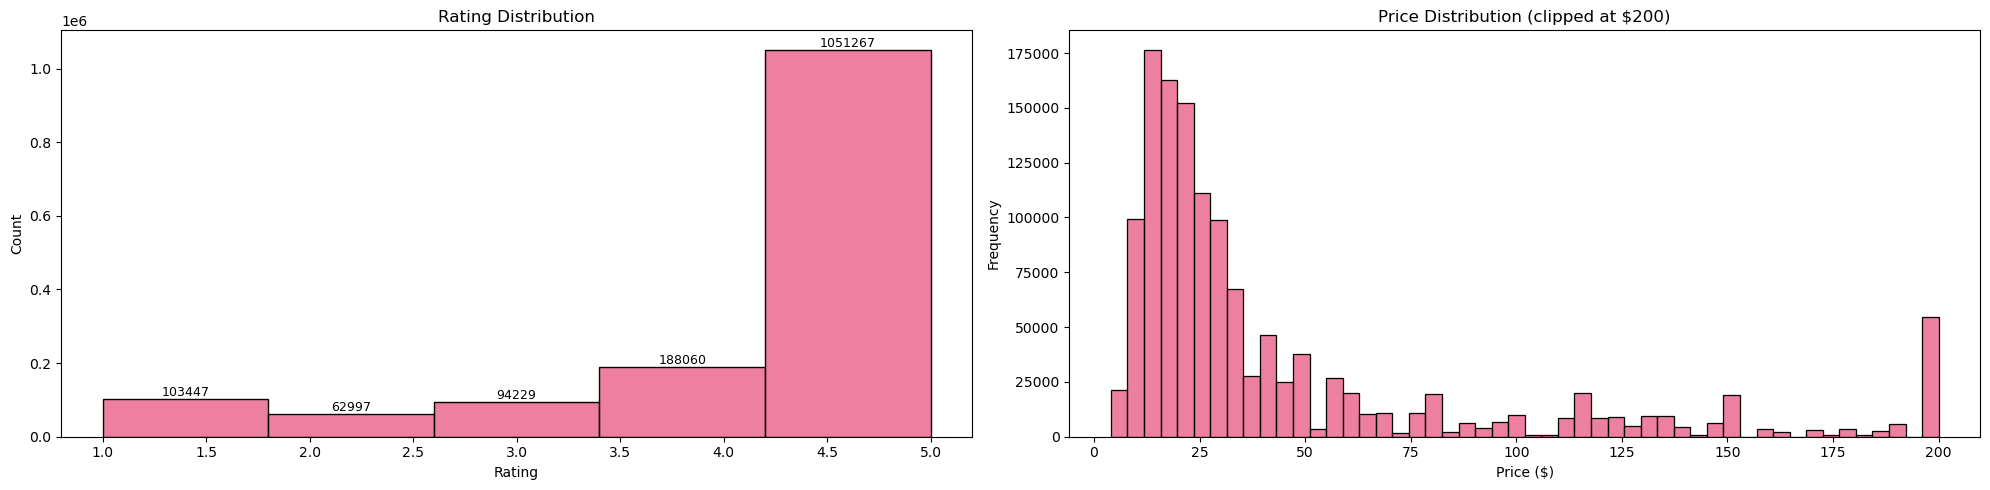

In [44]:
# EDA

pink_color = '#e75480'

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot 1: Rating Distribution
rating_plot = sns.histplot(
    df_final_cols['users_rating'].dropna(),
    bins=5, kde=False, edgecolor='black', color=pink_color, ax=axes[0]
)
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# Add labels on bars
for patch in rating_plot.patches:
    height = patch.get_height()
    if height > 0:
        rating_plot.annotate(
            f'{int(height)}',
            (patch.get_x() + patch.get_width() / 2, height),
            ha='center', va='bottom', fontsize=9, color='black'
        )

# Plot 2: Price Distribution (clipped at $200)
if 'item_price' in df_final_cols.columns:
    price_plot = sns.histplot(
        df_final_cols['item_price'].dropna().clip(0, 200),
        bins=50, kde=False, edgecolor='black', color=pink_color, ax=axes[1]
    )
    axes[1].set_title('Price Distribution (clipped at $200)')
    axes[1].set_xlabel('Price ($)')
    axes[1].set_ylabel('Frequency')

# Final layout
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [45]:
# === 1 FE: Semantic category extraction (hierarchical) ===
def safe_parse_categories(x):
    try:
        return json.loads(x) if isinstance(x, str) and x.strip().startswith('[') else []
    except:
        return []

df_cleaned['parsed_categories'] = df_cleaned['item_categories'].apply(safe_parse_categories)

# Extract up to 4 category levels
max_levels = 4
for i in range(max_levels):
    df_cleaned[f'category_level_{i}'] = df_cleaned['parsed_categories'].apply(
        lambda lst: lst[i].strip().lower() if i < len(lst) else None
    )

# Extract leaf category
df_cleaned['leaf_category'] = df_cleaned['parsed_categories'].apply(
    lambda lst: lst[-1].strip().lower() if len(lst) > 0 else None
)

# Drop intermediate list column
df_cleaned.drop(columns=['parsed_categories'], inplace=True)

# === 2 FE: Normalize main category ===
df_cleaned['item_main_category_cleaned'] = df_cleaned['item_main_category'].astype(str).str.strip().str.lower()

# === 3 FE: Simplify product title ===
df_cleaned['item_title_clean'] = df_cleaned['item_title'].str.split(',').str[0]

# === 4 FE: Top 100 most-reviewed products flag ===
top_asins = df_cleaned['users_parent_asin'].value_counts().head(100).index.tolist()
df_cleaned['is_top100'] = df_cleaned['users_parent_asin'].isin(top_asins).astype(int)

# === 5 FE: Flag for specific category ===
df_cleaned['is_sports_and_outdoors'] = (df_cleaned['item_main_category_cleaned'] == 'sports and outdoors').astype(int)

# === Define display order ===
ordered_cols = [
    # Core columns
    'users_user_id', 'users_parent_asin', 'users_rating',
    'item_title', 'item_categories', 'item_price', 'item_main_category',

    # Feature engineered
    'category_level_0', 'category_level_1', 'category_level_2', 'category_level_3',
    'leaf_category', 'item_main_category_cleaned', 'item_title_clean',
    'is_top100', 'is_sports_and_outdoors'
]

# === Display preview ===
existing_cols = [col for col in ordered_cols if col in df_cleaned.columns]
print("Sample of Cleaned + Feature Engineered Columns:")
display(df_cleaned[existing_cols].drop_duplicates().head(3))

Sample of Cleaned + Feature Engineered Columns:


,users_user_id,users_parent_asin,users_rating,item_title,item_categories,item_price,item_main_category,category_level_0,category_level_1,category_level_2,category_level_3,leaf_category,item_main_category_cleaned,item_title_clean,is_top100,is_sports_and_outdoors
0,ae6szo6fum4ue7wczo7ugp7qa5aa,b0b7qysgrp,1.0,"running buddy magnetic buddy pouch, beltess, c...","[""Sports & Outdoors"",""Sports"",""Running"",""Waist...",19.99,none,sports & outdoors,sports,running,waist packs,waist packs,none,running buddy magnetic buddy pouch,0,0
1,ago25x54uaixskhoah4sg2vuduna,b09lw2khpm,1.0,"vont led camping lantern, led lanterns, suitab...","[""Sports & Outdoors"",""Outdoor Recreation"",""Cam...",14.38,sports & outdoors,sports & outdoors,outdoor recreation,camping & hiking,lights & lanterns,electric lanterns,sports & outdoors,vont led camping lantern,1,0
2,ahggrlibawvh44xay2qhqoe7s6oq,b0btdlfxsl,5.0,ativafit exercise bike foldable fitness indoor...,"[""Sports & Outdoors"",""Exercise & Fitness"",""Car...",139.99,sports & outdoors,sports & outdoors,exercise & fitness,cardio training,exercise bikes,exercise bikes,sports & outdoors,ativafit exercise bike foldable fitness indoor...,0,0


## 4. Begin Sourcing Products for Cold Start Bundles

In [59]:
# Top 5 Most Frequent category_level_2

top_level2_counts = (
    df_cleaned['category_level_2']
    .value_counts(dropna=True)
    .head(5)
    .reset_index()
    .rename(columns={'index': 'category_level_2', 'category_level_2': 'count'})
)

print("Top 5 Most Frequent category_level_2 Values:")
display(top_level2_counts)

Top 5 Most Frequent category_level_2 Values:


,count,count
0,camping & hiking,312550
1,cycling,127640
2,accessories,97231
3,strength training equipment,95628
4,fitness technology,79451


In [50]:
# Define top 5 category_level_2 values
top_level2_values = [
    'camping & hiking',
    'cycling',
    'accessories',
    'strength training equipment',
    'fitness technology'
]

# Filter to only rows with top 5 category_level_2
filtered_df = df_cleaned[df_cleaned['category_level_2'].isin(top_level2_values)]

# Group by category_level_2 and leaf_category, count occurrences
grouped_leaf_counts = (
    filtered_df
    .groupby(['category_level_2', 'leaf_category'])
    .size()
    .reset_index(name='count')
    .sort_values(['category_level_2', 'count'], ascending=[True, False])
)

# Display top 5 leaf categories per category_level_2
print("Top Leaf Categories for Each Top category_level_2:")
top_leaf_by_level2 = grouped_leaf_counts.groupby('category_level_2').head(5)
display(top_leaf_by_level2)


Top Leaf Categories for Each Top category_level_2:


,category_level_2,leaf_category,count
5,accessories,exercise balls,13662
6,accessories,exercise equipment mats,9137
9,accessories,gloves,8911
4,accessories,bike racks,7810
10,accessories,hydration packs,6448
36,camping & hiking,electric lanterns,28134
49,camping & hiking,hiking daypacks,22384
75,camping & hiking,trekking poles,20763
33,camping & hiking,coolers,19464
28,camping & hiking,chairs,18696


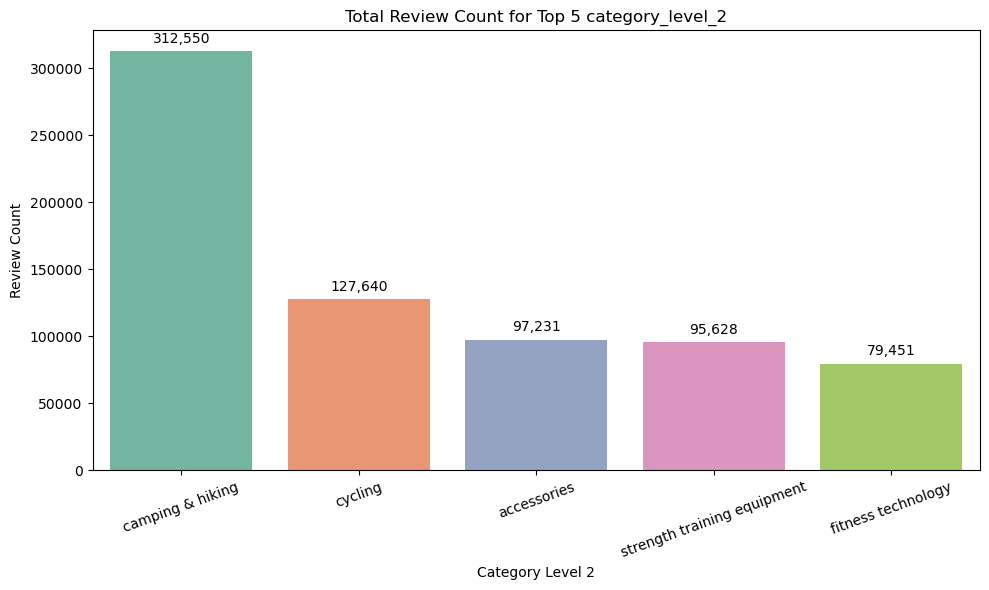

In [57]:
# Define top 5 categories manually
top_categories = [
    'camping & hiking',
    'cycling',
    'accessories',
    'strength training equipment',
    'fitness technology'
]

# Filter and aggregate counts
category_totals_df = (
    df_cleaned[df_cleaned['category_level_2'].isin(top_categories)]
    .groupby('category_level_2')
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=category_totals_df,
    x='category_level_2',
    y='count',
    hue='category_level_2',  # For coloring
    palette='Set2',
    dodge=False
)

# Remove legend
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Annotate counts
for bar in ax.patches:
    height = bar.get_height()
    if not pd.isna(height):
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=10)

# Final plot settings
plt.title('Total Review Count for Top 5 category_level_2')
plt.xlabel('Category Level 2')
plt.ylabel('Review Count')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()